# Bike Sharing Demand

In [2]:
# pip install missingno

Note: you may need to restart the kernel to use updated packages.


- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered - clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [82]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats

import missingno as msno
plt.style.use('seaborn')

import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['axes.unicode_minus'] = False

%matplotlib inline

# 기본적인 모듈을 import 합니다. 
# mlp.rcParams['axes.unicode_minus'] = False 코드는 그래프에서 마이너스 폰트가 깨지는 문제에 대한 대처입니다.

## 데이터 불러오기 
## Import & Data Check

In [83]:
# 데이터 불러오기
df_train = pd.read_csv("./train.csv", parse_dates = ["datetime"])
df_test = pd.read_csv("./test.csv", parse_dates = ["datetime"])
# 여기서 parse_dates 는 날짜, 시간변수를 datetime 변수로 변환하기 위함

In [84]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [85]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [86]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


<AxesSubplot:>

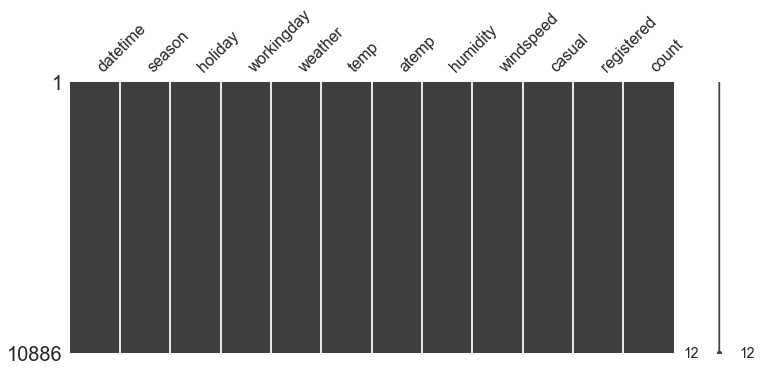

In [87]:
msno.matrix(df_train, figsize = (12,5))

# 꽉꽉 들어차있는 것을 보니 결측치가 없는 것으로 판단

Skewness : 1.242066
Kurtosis : 1.300093


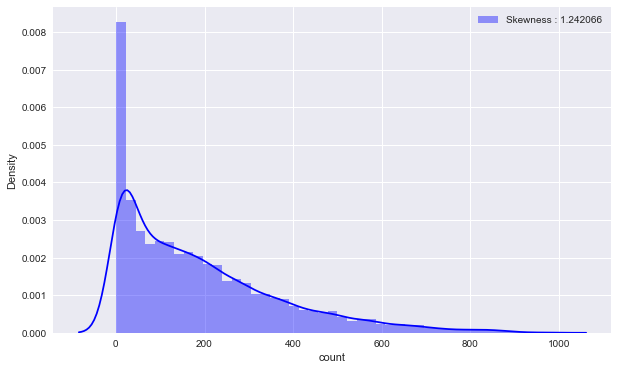

In [88]:
# 타겟변수인 count 의 Skewness와 Kurtosis 확인

f,ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df_train["count"], color = "b", label = 
                 "Skewness : {:2f}".format(df_train["count"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness : %f" % df_train['count'].skew())
print("Kurtosis : %f" % df_train['count'].kurt())

# 왜도가 1이 넘으니 왼쪽으로 치우침 : 상당히 치우쳐있다.
# 첨도가 1이 넘으니 표준정규분포보다 조금 더 완만함 이상값이 많나

# 대부분의 데이터가 0에 몰려있는 것을 확인할 수 있다.

# EDA

In [89]:
# Datetime 먼저 살펴보기
# 연,월,일,시,분,초 로 나누어준다
df_train['year'] = df_train['datetime'].dt.year
df_train['month'] = df_train['datetime'].dt.month
df_train['day'] = df_train['datetime'].dt.day
df_train['hour'] = df_train['datetime'].dt.hour
df_train['minute'] = df_train['datetime'].dt.minute
df_train['second'] = df_train['datetime'].dt.second

df_test['year'] = df_test['datetime'].dt.year
df_test['month'] = df_test['datetime'].dt.month
df_test['day'] = df_test['datetime'].dt.day
df_test['hour'] = df_test['datetime'].dt.hour
df_test['minute'] = df_test['datetime'].dt.minute
df_test['second'] = df_test['datetime'].dt.second

df_train.shape

# 칼럼이 18개로 늘어났다.

(10886, 18)

In [90]:
df_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19,0,0
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20,0,0
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21,0,0
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22,0,0


[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental amount by hour')]

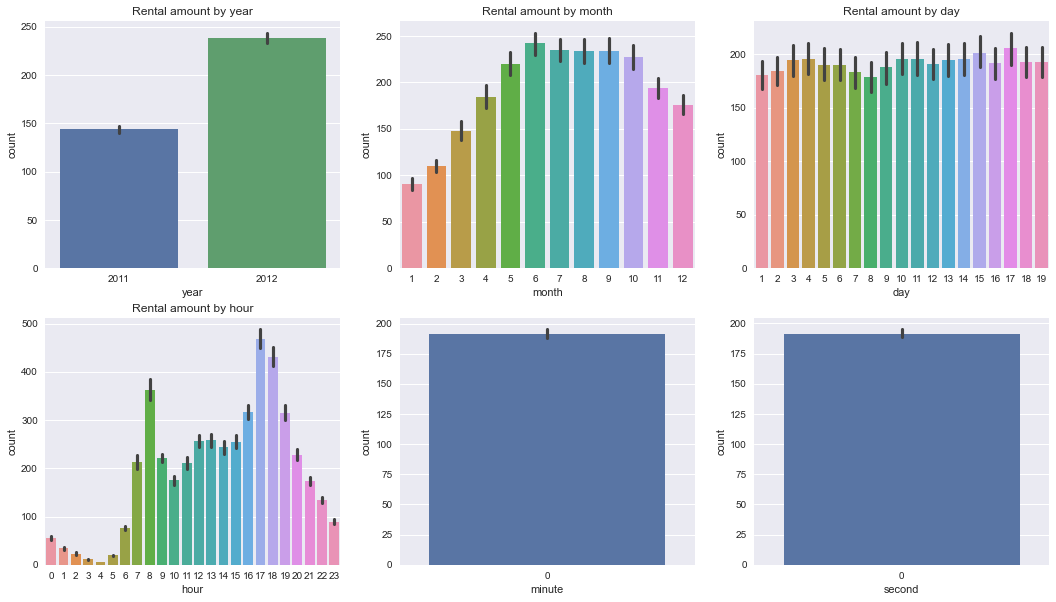

In [91]:
# barplot 을 이용하여 시각화

figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3)
figure.set_size_inches(18,10)

sns.barplot(data = df_train, x = "year", y="count", ax = ax1)
sns.barplot(data = df_train, x = "month", y="count", ax = ax2)
sns.barplot(data = df_train, x = "day", y="count", ax = ax3)
sns.barplot(data = df_train, x = "hour", y="count", ax = ax4)
sns.barplot(data = df_train, x = "minute", y="count", ax = ax5)
sns.barplot(data = df_train, x = "second", y="count", ax = ax6)

ax1.set(ylabel = "count", title = "Rental amount by year")
ax2.set(ylabel = "count", title = "Rental amount by month")
ax3.set(ylabel = "count", title = "Rental amount by day")
ax4.set(ylabel = "count", title = "Rental amount by hour")

- 2012년에 대여량이 더 늘어남
- 월별로 보면 겨울보다 여름에 대여량이더 높다.
- 일별 차이는 거의 없다. 1일에서 19일까지의 데이터가 있음 나머지는 test에 있다고..
- 시간으로 봤을 땐 7시가 눈에 띄고 그 다음은 오후 5시부터 6-7시에 많다. 출,퇴근시간에 이용하는듯

In [92]:
# 요일변수를 추가로 생성
df_train['dayofweek'] = df_train['datetime'].dt.dayofweek
df_test['dayofweek'] = df_test['datetime'].dt.dayofweek
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0,5


In [93]:
# 범주의 갯수 세기
# 0 은 월요일 6일이 일요일
df_train['dayofweek'].value_counts()

# 큰 차이는 없으나 5 토요일, 6 일요일에 조금 더 많아보인다.

5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

<AxesSubplot:xlabel='hour', ylabel='count'>

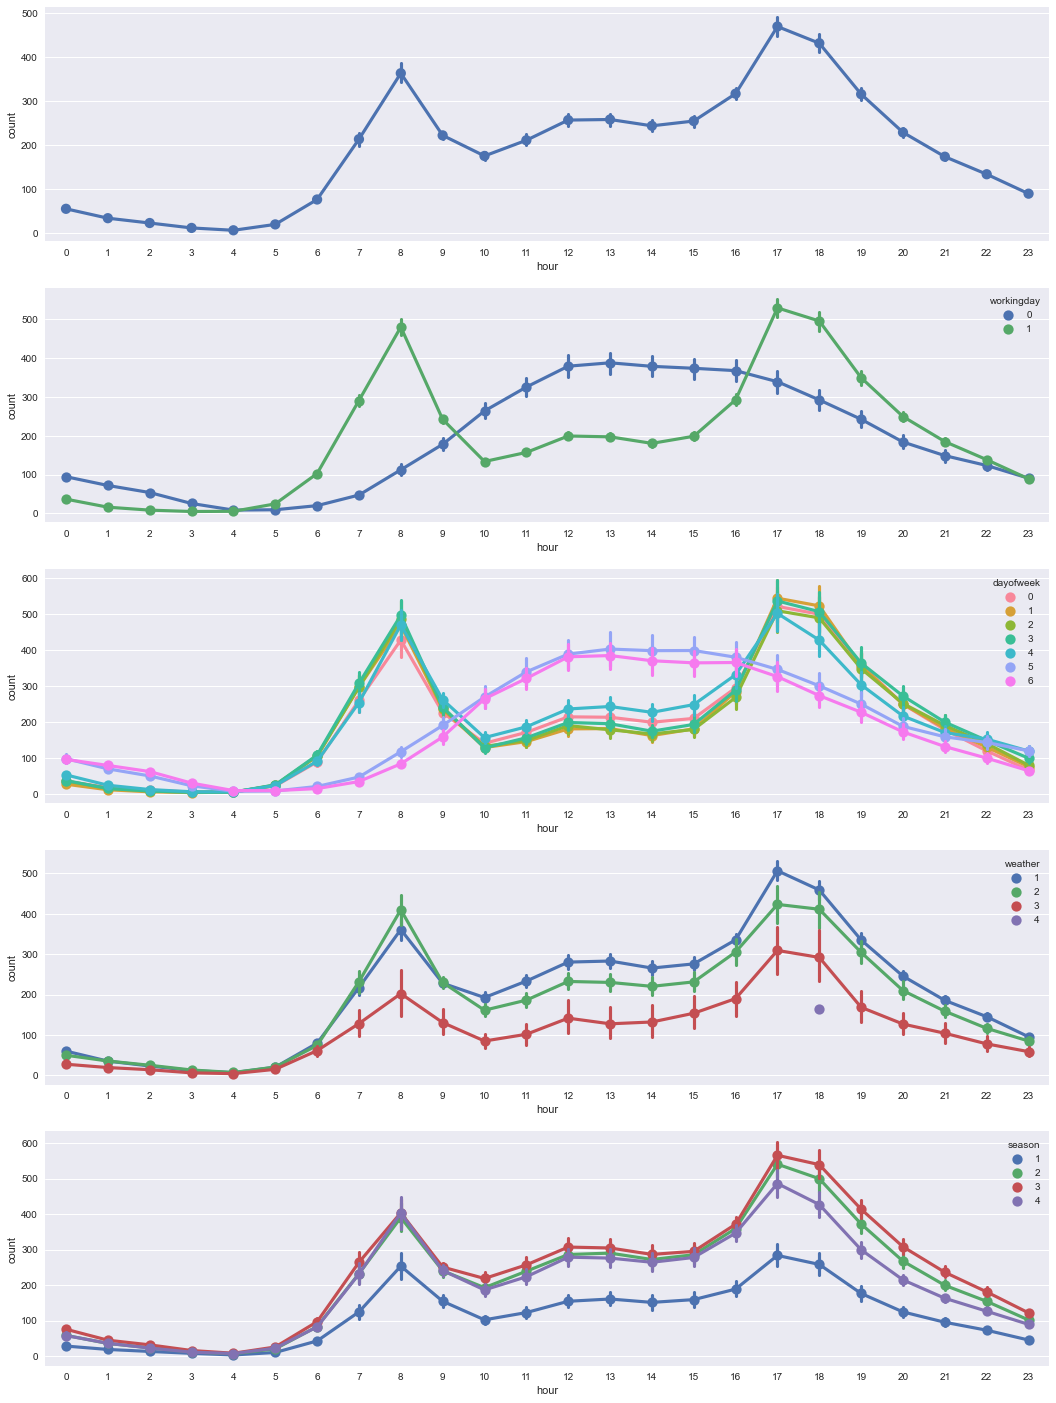

In [94]:
# 시간의 흐름에 따른 pointplot 을 그려주자.
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5)
fig.set_size_inches(18,25)

sns.pointplot(data = df_train, x = "hour", y="count", ax = ax1)
sns.pointplot(data = df_train, x = "hour", y="count", hue = 'workingday', ax= ax2)
sns.pointplot(data = df_train, x = "hour", y="count", hue = 'dayofweek', ax = ax3)
sns.pointplot(data = df_train, x = "hour", y="count", hue = 'weather', ax = ax4)
sns.pointplot(data = df_train, x = "hour", y="count", hue = 'season', ax = ax5)

- Working day 를 보았을 때 , 주말에는 10-16시일 때 가장 많음
- dayofweek 를 보아도 마찬가지.
- weather 를 보면 heavy rain이 올 때는 자전거 안 탐. 당연함 ..
- 맑을 때 많이 타네요
- season을 보면 의외로 봄에 안 타넹 가을,여름 순으로 많이 탐 

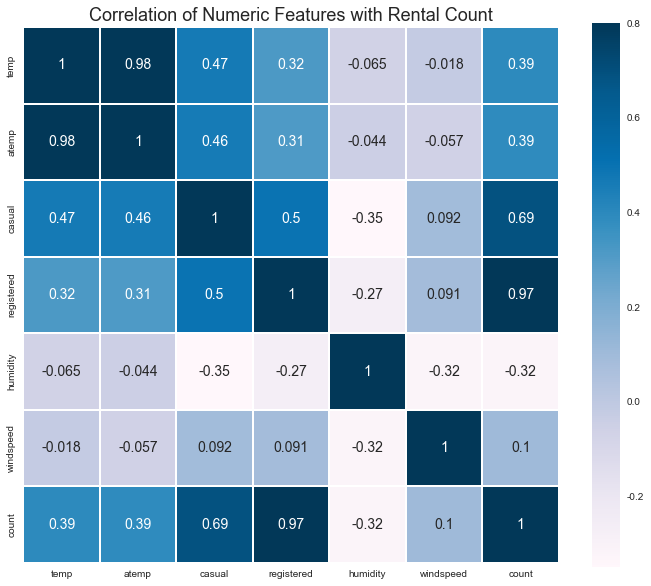

In [95]:
corr_data = df_train[['temp','atemp','casual','registered','humidity','windspeed','count']]

colormap = plt.cm.PuBu

f, ax = plt.subplots(figsize = (12,10))
plt.title("Correlation of Numeric Features with Rental Count", y=1, size=18)
sns.heatmap(corr_data.corr(), vmax=0.8, linewidths=0.1, square=True, annot = True,
            cmap=colormap, linecolor="white", annot_kws={'size':14})

plt.show()

- 눈에 띄게 가장 진한 변수는 registered. 이 변수는 test에는 존재하지 않는다.
- 그 다음으로는 casual (non-registered)
- temp와 atemp는 온도, 체감온도인데 상관계수가 높은 것을 봐서 다중공선성을 보인다고 할 수 있다.
- 온도,습도,풍속은 거의 관계가 없다.

<AxesSubplot:xlabel='humidity', ylabel='count'>

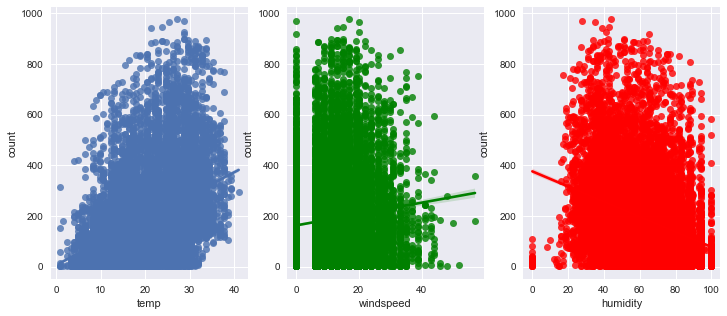

In [96]:
# Heatmap을 통해 유의하지 않다고 판단된 변수에 대해서 scatter plot을 그려본다.
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,5))

temp_scatter_plot = pd.concat([df_train['count'],df_train['temp']], axis=1)
sns.regplot(x='temp', y='count', data = temp_scatter_plot, scatter=True, fit_reg=True, ax=ax1)
windspeed_scatter_plot = pd.concat([df_train['count'],df_train['windspeed']], axis=1)
sns.regplot(x='windspeed', y='count', data= windspeed_scatter_plot, scatter=True, 
            color = 'green', fit_reg=True, ax=ax2)
humidity_scatter_plot = pd.concat([df_train['count'], df_train['humidity']], axis=1)
sns.regplot(x='humidity', y='count', data=humidity_scatter_plot, scatter=True, 
            color = 'red', fit_reg=True, ax=ax3)

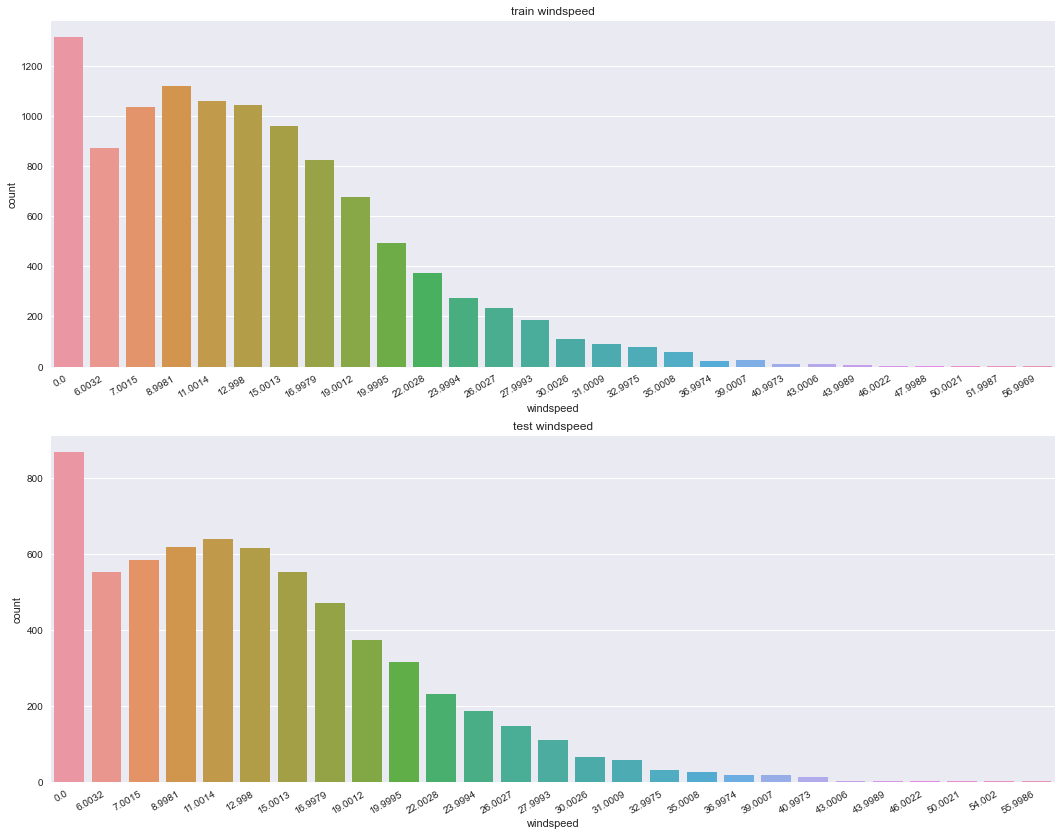

In [97]:
fig, axes = plt.subplots(nrows=2, figsize= (18,14))

plt.sca(axes[0])
plt.xticks(rotation=30, ha="right")
axes[0].set(ylabel="count", title = "train windspeed")
sns.countplot(data = df_train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation = 30, ha='right')
axes[1].set(ylabel="count", title='test windspeed')
sns.countplot(data=df_test, x= 'windspeed', ax=axes[1])

plt.show()

- windspeed가 0에 값이 많이 몰려있었으므로 자세한 시각화를 해주었다.
- 0에 대한 값이 매우 많으므로 Feature Engineering 에서 고쳐주도록 하자.

In [98]:
def concatenate_year_month(datetime):
    return "{0}-{1}".format(datetime.year, datetime.month)

df_train['year_month'] = df_train['datetime'].apply(concatenate_year_month)
df_test['year_month'] = df_test['datetime'].apply(concatenate_year_month)

print(df_train.shape)
df_train[['datetime','year_month']].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


연도별 데이터의 대여 변화를 좀 더 자세히 보기 위해서 year와 month 데이터를 붙여준다.

<AxesSubplot:xlabel='year_month', ylabel='count'>

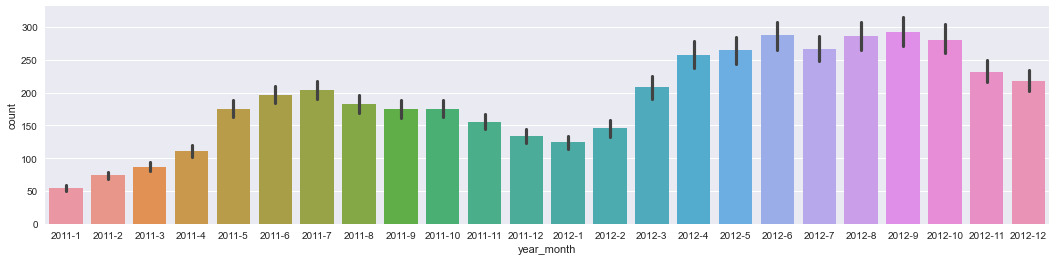

In [99]:
fig, ax = plt.subplots(figsize = (18,4))
sns.barplot(data =df_train, y="count", x="year_month")

- 2012-3 ~~ 2012-10 까지 높다
- 그리고 갈수록 대여량이 더 높아지고있는 추세


In [100]:
# IQR 을 이용해서 이상치 제거

from collections import Counter 

def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        
Outliers_to_drop = detect_outliers(df_train, 2, ["temp", "atemp", "casual", 
                                                 "registered", "humidity", "windspeed", "count"])

In [101]:
df_train.loc[outliers_to_drop]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second,dayofweek,year_month
9243,2012-09-08 12:00:00,3,0,0,1,32.80,37.880,55,32.9975,220,474,694,2012,9,8,12,0,0,5,2012-9
9244,2012-09-08 13:00:00,3,0,0,1,33.62,38.635,52,35.0008,233,435,668,2012,9,8,13,0,0,5,2012-9
9652,2012-10-06 13:00:00,4,0,0,2,26.24,31.060,57,35.0008,310,400,710,2012,10,6,13,0,0,5,2012-10
9655,2012-10-06 16:00:00,4,0,0,1,24.60,31.060,43,35.0008,317,342,659,2012,10,6,16,0,0,5,2012-10


In [102]:
df_train = df_train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
df_train.shape

(10846, 20)

In [103]:
df_train_num = df_train[['count','temp','atemp','casual','registered','humidity','windspeed']]

In [104]:
for col in df_train_num :
    print('{:15}'.format(col),
         'Skewness : {:05.2f}'.format(df_train[col].skew()),
         '  ',
         "Kurtosis : {:06.2f}".format(df_train[col].kurt()))

count           Skewness : 01.21    Kurtosis : 001.20
temp            Skewness : 00.01    Kurtosis : -00.91
atemp           Skewness : -0.10    Kurtosis : -00.85
casual          Skewness : 02.52    Kurtosis : 007.74
registered      Skewness : 01.51    Kurtosis : 002.61
humidity        Skewness : -0.09    Kurtosis : -00.76
windspeed       Skewness : 00.58    Kurtosis : 000.63


[Text(0, 0.5, 'count'), Text(0.5, 1.0, 'Rental count by minute')]

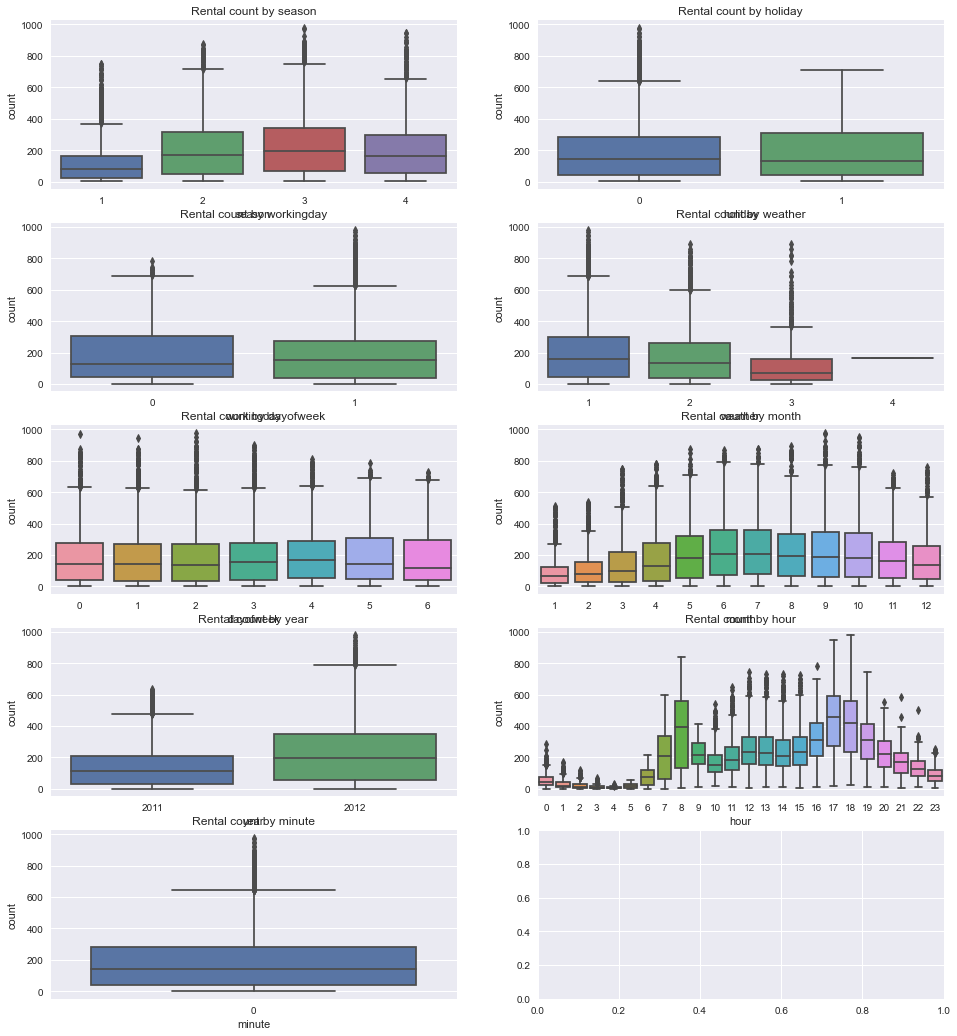

In [105]:
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (16,18))
sns.boxplot(data = df_train, y="count", x = "season", orient="v", ax = axes[0][0])
sns.boxplot(data = df_train, y="count", x = "holiday", orient="v", ax = axes[0][1])
sns.boxplot(data = df_train, y="count", x = "workingday", orient="v", ax = axes[1][0])
sns.boxplot(data = df_train, y="count", x = "weather", orient="v", ax = axes[1][1])
sns.boxplot(data = df_train, y="count", x = "dayofweek", orient="v", ax = axes[2][0])
sns.boxplot(data = df_train, y="count", x = "month", orient="v", ax = axes[2][1])
sns.boxplot(data = df_train, y="count", x = "year", orient="v", ax = axes[3][0])
sns.boxplot(data = df_train, y="count", x = "hour", orient="v", ax = axes[3][1])
sns.boxplot(data = df_train, y="count", x = "minute", orient="v", ax = axes[4][0])

axes[0][0].set(ylabel = "count", title="Rental count by season")
axes[0][1].set(ylabel = "count", title="Rental count by holiday")
axes[1][0].set(ylabel = "count", title="Rental count by workingday")
axes[1][1].set(ylabel = "count", title="Rental count by weather")
axes[2][0].set(ylabel = "count", title="Rental count by dayofweek")
axes[2][1].set(ylabel = "count", title="Rental count by month")
axes[3][0].set(ylabel = "count", title="Rental count by year")
axes[3][1].set(ylabel = "count", title="Rental count by hour")
axes[4][0].set(ylabel = "count", title="Rental count by minute")

# Feature Engineering

Skewness : 1.210923
Kurtosis : 1.200871


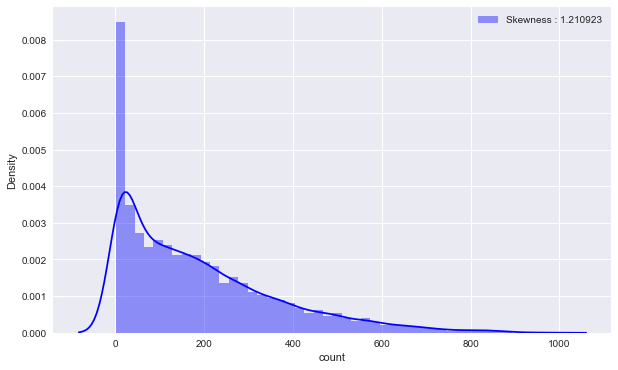

In [106]:
f,ax = plt.subplots(1, 1, figsize = (10,6))
g = sns.distplot(df_train["count"], color = "b", label = 
                 "Skewness : {:2f}".format(df_train["count"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness : %f" % df_train['count'].skew())
print("Kurtosis : %f" % df_train['count'].kurt())

Skewness : -0.975198
Kurtosis : 0.247435


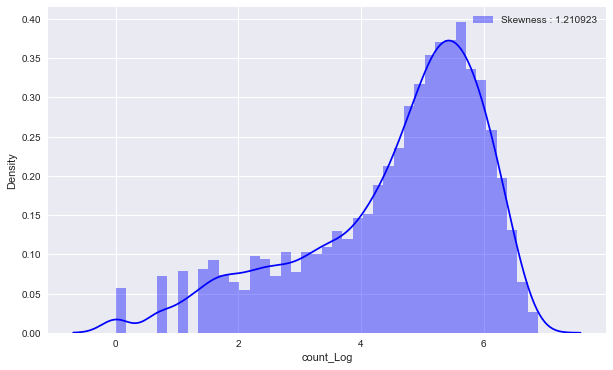

In [107]:
# Log Scaling 을 통해서 치우쳐진 값을 정규화

df_train['count_Log'] = df_train['count'].map(lambda i:np.log(i) if i>0 else 0)

f,ax = plt.subplots(1,1, figsize = (10,6))
g = sns.distplot(df_train["count_Log"], color = "b", label = 
                 "Skewness : {:2f}".format(df_train["count"].skew()), ax=ax)
g = g.legend(loc = "best")

print("Skewness : %f" % df_train['count_Log'].skew())
print("Kurtosis : %f" % df_train['count_Log'].kurt())

In [108]:
df_train.drop('count', axis=1, inplace = True)

In [110]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,year,month,day,hour,minute,second,dayofweek,year_month,count_Log
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,2011,1,1,0,0,0,5,2011-1,2.772589
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,2011,1,1,1,0,0,5,2011-1,3.688879
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,2011,1,1,2,0,0,5,2011-1,3.465736
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,2011,1,1,3,0,0,5,2011-1,2.564949
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,2011,1,1,4,0,0,5,2011-1,0.000000


In [112]:
trainwind0 = df_train.loc[df_train['windspeed'] == 0]
trainWindNot0 = df_train.loc[df_train['windspeed'] != 0 ]

- 우리는 위에서 풍속이 0인 값이 매우 많은 것을 확인했다.
- 하지만 상식적으로 0인 풍속은 측정이 어렵기 때문에 이가 Null값을 대체한 것이라고 보는 것이 낫다.
- 0을 채워주기 위해서 우리는 RandomForest를 사용할 것이다.
- 풍속을 Target변수로, 나머지 변수를 독립변수로.

In [113]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
def predict_windspeed(data):
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    wcol = ['season', 'weather', 'humidity', 'day', 'temp', 'atemp']
    
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
    
    rf_wind = RandomForestClassifier()
    rf_wind.fit(dataWindNot0[wcol], dataWindNot0['windspeed'])
    wind0 = rf_wind.predict(X=dataWind0[wcol])
    
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    predictWind0['windspeed'] = wind0
    
    data = predictWindNot0.append(predictWind0)
    
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace = True)
    data.drop('index', inplace = True, axis = 1)
    
    return data

<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

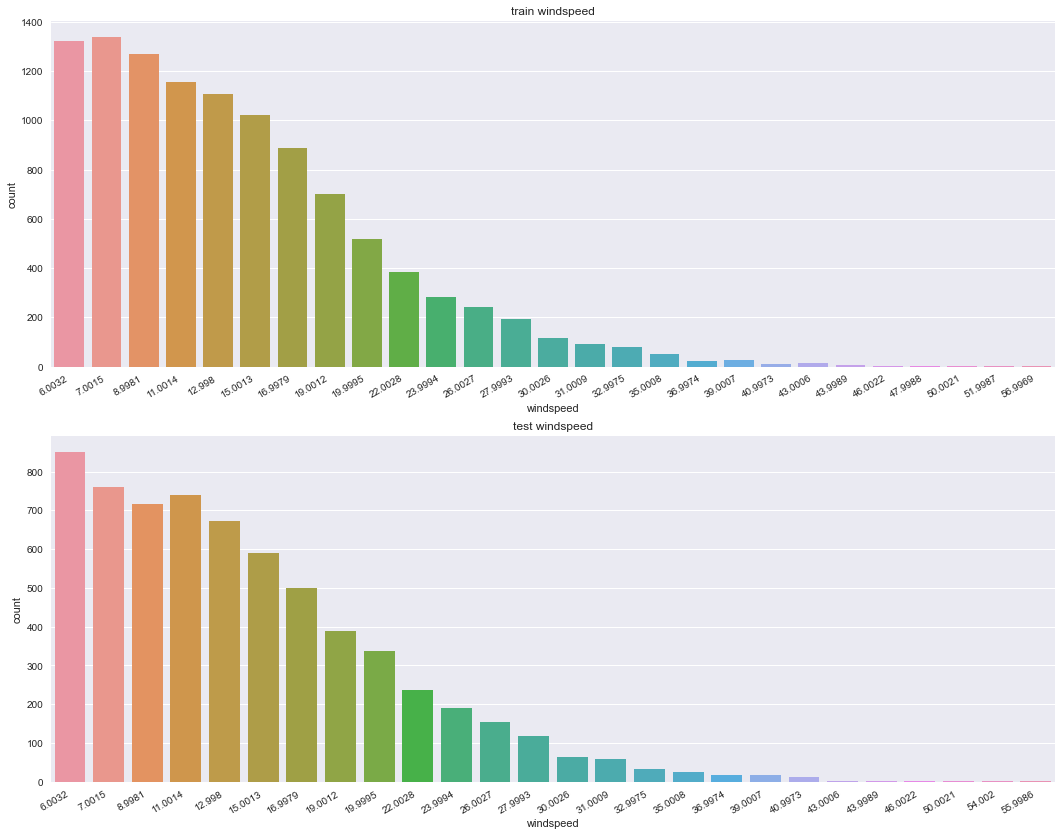

In [123]:
df_train = predict_windspeed(df_train)
df_test = predict_windspeed(df_test)

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (18,14))

plt.sca(ax1)
plt.xticks(rotation = 30, ha = "right")
ax1.set(ylabel = "count", title = "train windspeed")
sns.countplot(data = df_train, x = "windspeed", ax = ax1)

plt.sca(ax2)
plt.xticks(rotation = 30, ha = "right")
ax2.set(ylabel = "count", title = "test windspeed")
sns.countplot(data = df_test, x = "windspeed", ax = ax2)

In [126]:
# 상관계수 확인
corr_data = df_train[["count_Log", "windspeed"]]
corr_data.corr()

,count_Log,windspeed
count_Log,1.000000,0.125572
windspeed,0.125572,1.000000


In [127]:
# 범주형 변수들 원핫인코딩 (1,0 으로. 칼럼도 새로 생성암)
df_train = pd.get_dummies(df_train, columns = ["weather"], prefix = "weather")
df_test = pd.get_dummies(df_test, columns = ["weather"], prefix = "weather")

df_train = pd.get_dummies(df_train, columns = ["season"], prefix = "season")
df_test = pd.get_dummies(df_test, columns = ["season"], prefix = "season")

In [128]:
# train, test 정리하고 마무리 
datetime_test = df_test['datetime']

df_train.drop(["datetime", "registered","casual","holiday", "year_month", "minute", "second"], axis = 1, inplace = True)
df_test.drop(["datetime","holiday", "year_month", "minute", "second"], axis = 1, inplace = True)

In [130]:
df_train.head()

,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,count_Log,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4
0,0,9.84,12.880,75,6.0032,2011,1,1,5,5,0.000000,0,1,0,0,1,0,0,0
1,0,15.58,19.695,76,16.9979,2011,1,1,10,5,3.583519,1,0,0,0,1,0,0,0
2,0,14.76,16.665,81,19.0012,2011,1,1,11,5,4.025352,1,0,0,0,1,0,0,0
3,0,17.22,21.210,77,19.0012,2011,1,1,12,5,4.430817,1,0,0,0,1,0,0,0
4,0,18.86,22.725,72,19.9995,2011,1,1,13,5,4.543295,0,1,0,0,1,0,0,0


In [131]:
df_test.head()

,workingday,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4
0,1,10.66,11.365,56,26.0027,2011,1,20,0,3,1,0,0,0,1,0,0,0
1,1,10.66,12.880,56,11.0014,2011,1,20,3,3,1,0,0,0,1,0,0,0
2,1,10.66,12.880,56,11.0014,2011,1,20,4,3,1,0,0,0,1,0,0,0
3,1,9.84,11.365,60,15.0013,2011,1,20,5,3,1,0,0,0,1,0,0,0
4,1,9.02,10.605,60,15.0013,2011,1,20,6,3,1,0,0,0,1,0,0,0


# Modeling 

In [132]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train = df_train.drop("count_Log", axis=1).values
target_label = df_train["count_Log"].values
X_test = df_test.values
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.2, 
                                           random_state = 2000)

In [133]:
# Gradient Boost 사용
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor(n_estimators = 2000, learning_rate = 0.05,
                                     max_depth = 4,
                                     min_samples_leaf= 15, min_samples_split=10,
                                     random_state = 42)

regressor.fit(X_tr,y_tr)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, min_samples_leaf=15,
                          min_samples_split=10, n_estimators=2000,
                          random_state=42)

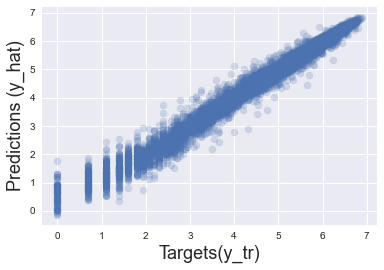

In [134]:
y_hat = regressor.predict(X_tr)
plt.scatter(y_tr, y_hat, alpha = 0.2)
plt.xlabel('Targets(y_tr)', size= 18)
plt.ylabel("Predictions (y_hat)", size = 18)
plt.show()

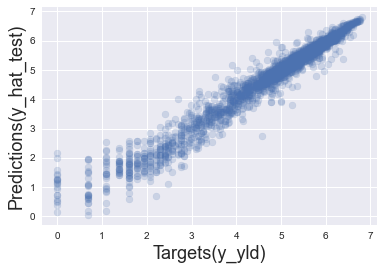

In [135]:
y_hat_test = regressor.predict(X_vld)
plt.scatter(y_vld, y_hat_test, alpha=0.2)
plt.xlabel("Targets(y_yld)", size = 18)
plt.ylabel("Predictions(y_hat_test)", size=18)
plt.show()

In [144]:
# 정확도 확인
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

models=[GradientBoostingRegressor()]
model_names=['regressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(X_tr,y_tr)
    test_pred=clf.predict(X_vld)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred,y_vld)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}   
d

{'Modelling Algo': ['regressor'], 'RMSLE': [0.1342902879875913]}

In [145]:
from sklearn.model_selection import cross_val_score 
accuracies = cross_val_score(estimator = regressor, X = X_tr, y = y_tr, cv = 8)

In [146]:
print(accuracies.mean()) 
print(accuracies.std())

0.95667106187069
0.0035836216554062743


In [147]:
use_logvals = 1

pred_xgb = regressor.predict(X_test)

sub_xgb = pd.DataFrame()
sub_xgb['datetime'] = datetime_test
sub_xgb['count'] = pred_xgb
if use_logvals == 1:
    sub_xgb['count'] = np.exp(sub_xgb['count'])
    
sub_xgb.to_csv("xgb.csv", index=False)